# Pneumonia Classification in Chest X-rays using CNN

Convolutional Neural Networks (CNNs)

In the field of deep learning, the ability of machines to interpret visual data has been revolutionized by architectures that mimic biological processes. As O’Shea and Nash (2015) point out in their foundational work:

> "Artificial Neural Networks (ANNs) are computational processing systems of which are heavily inspired by way biological nervous systems (such as the human brain) operate."

This biological inspiration led to the development of **Convolutional Neural Networks (CNNs)**, a specialized class of networks designed to solve the inherent limitations of traditional architectures when dealing with high-dimensional data. Before CNNs, processing images meant "flattening" pixels into a single vector, a process that not only exploded the number of parameters to an unmanageable scale but also completely ignored the spatial hierarchy—the relationship between neighboring pixels that forms shapes and objects.

CNNs address these challenges through the mathematical operation of **convolution**, which allows the network to learn local patterns (such as edges, textures, and colors) that are invariant to their position in the image. By stacking convolutional layers and pooling operations, these networks can abstract simple features into complex concepts, making them the standard for a wide range of applications: from medical diagnosis in X-rays and MRI scans to the real-time perception systems of autonomous vehicles.

You can find more details in the original paper: [An Introduction to Convolutional Neural Networks](https://arxiv.org/abs/1511.08458)


This notebook presents the development of a Convolutional Neural Network (CNN) designed to detect pneumonia from **chest X-ray images**.

### 1. Environment Setup and Imports

In this section, the necessary libraries for tensor processing (PyTorch), visualization (Matplotlib), and evaluation metrics were loaded.


In [21]:

# Core deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data handling
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Numerical and visualization
import numpy as np
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# System
import os
import sys
import seaborn as sns

### 2. Data Loading and Preprocessing

The system paths were configured to access local modules and the dataloaders were initialized. An image size of 224x224 was selected to balance detail and computational cost.


In [22]:
# Go up one level to reach the project root and enter 'src'
sys.path.append(os.path.abspath(os.path.join("..")))

# Import custom dataloaders
from src.data.dataloaders import get_loaders

# Execute the function to get data loaders
# batch_size=32 is a stable standard for training
train_loader, test_loader = get_loaders(batch_size=32, model_type="cnn")

print(f"train_loader variable defined: {train_loader is not None}")

Apple Silicon detected. Setting num_workers to 0 for compatibility.
train_loader variable defined: True


### 3. Model Architecture (PneumoniaCNN)

A custom architecture with 3 convolutional blocks was designed. Each block extracted features ranging from low-level edges to high-level lung opacity patterns.


In [23]:
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaCNN, self).__init__()
        
        # Block 1: Initial feature extraction
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 2: Depth increase
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 3: Complex features extraction
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# The model was instantiated and dimensions were verified
model = PneumoniaCNN(num_classes=2)
print("Model structure was successfully verified.")

Model structure was successfully verified.


### 4. Training Configuration

The hardware was selected. Since an Apple M1 chip was used, the Metal Performance Shaders (MPS) backend was prioritized to leverage the integrated GPU, falling back to CPU only if necessary.


In [24]:
# Hardware selection (Optimized for Apple M1/M2/M3)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Training on: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Training on: CPU")

model = model.to(device)

# CrossEntropyLoss was chosen for classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer was initialized with a learning rate of 1e-4 and weight decay

optimizer = optim.Adam(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-4  
)


# A scheduler was implemented to reduce LR on plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2)

Training on: Apple Silicon GPU (MPS)


### 5. Training Loop Definition

A function was created to manage the training process, error calculation, and weight optimization.


In [25]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=3):
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    best_loss = float("inf")
    epochs_no_improve = 0
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct_test / total_test

        
        # Metrics were stored in history
        history["train_loss"].append(epoch_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(epoch_acc)
        history["test_acc"].append(test_acc)
        
       # print training and validation metrics
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
        print(f"Test  Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")

        # Save the best model based on test loss with early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved")
        else:
            epochs_no_improve += 1
            print(f"No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

   

        
    return history

### 6. Visualization of Results

A set of functions was developed to monitor the model's convergence during the training process. These visualizations allowed for a direct comparison between the training and testing datasets, ensuring that the learning rate and architecture were appropriate for the task.


In [26]:
# Ensure directories exist.
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../models_saved", exist_ok=True)


# 1. Function to plot training curves for CNN model.

def plot_training_curves(history):
    """
    Plots training curves for a single-phase model (CNN).
    Args:
        history: Dictionary containing 'train_loss', 'test_loss', 'train_acc', 'test_acc'
    """
    
    epochs = len(history["train_loss"])
    epochs_range = list(range(1, epochs + 1))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Figure 1: Loss.
    axes[0].plot(epochs_range, history["train_loss"], "o-", label="Train Loss", linewidth=2, color="#3498db")
    axes[0].plot(epochs_range, history["test_loss"], "s-", label="Val/Test Loss", linewidth=2, color="#e74c3c")
    
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_title("Loss Evolution (CNN)", fontsize=14, weight="bold")
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Figure 2: Accuracy.
    axes[1].plot(epochs_range, history["train_acc"], "o-", label="Train Acc", linewidth=2, color="#2ecc71")
    axes[1].plot(epochs_range, history["test_acc"], "s-", label="Val/Test Acc", linewidth=2, color="#9b59b6")
    
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Accuracy (%)", fontsize=12)
    axes[1].set_title("Accuracy Evolution (CNN)", fontsize=14, weight="bold")
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Detect Overfitting zone (Gap > 10%).
    train_acc_arr = np.array(history["train_acc"])
    test_acc_arr = np.array(history["test_acc"])
    gaps = train_acc_arr - test_acc_arr
    max_gap = np.max(gaps)
    
    if max_gap > 10:
        axes[1].fill_between(epochs_range, train_acc_arr, test_acc_arr, 
                            where=(gaps > 0),
                            alpha=0.1, color="red", 
                            label=f"Max Gap: {max_gap:.1f}%")
        axes[1].legend(fontsize=10)
    
    plt.tight_layout()
    plt.savefig("../results/figures/cnn_training_curves.png", dpi=300, bbox_inches="tight")
    plt.show()


# 2. Function to evaluate model and get predictions.

def evaluate_model(model, test_loader, device):
    """
    Runs the model on the test set and returns the lists
    needed for the confusion matrix and ROC curve.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("\nGenerating predictions for evaluation...")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Probabilities (softmax) for ROC curve
            probs = torch.softmax(outputs, dim=1)
            
            # Final predictions (class 0 or 1)
            _, predicted = torch.max(outputs, 1)
            
            # Move to CPU for numpy processing
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Assuming class 1 is PNEUMONIA, we save its probability
            all_probs.extend(probs[:, 1].cpu().numpy())
            
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


# 3. Function for confusion matrix and ROC.

def plot_confusion_matrix_and_roc(labels, preds, probs):
    """
    Generates confusion matrix and ROC curve based on test set predictions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Figure 3: Confusion Matrix.
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"],
                ax=axes[0], annot_kws={"size": 16}, cbar=False)

    axes[0].set_title("Confusion Matrix (CNN)", fontsize=14, weight="bold")
    axes[0].set_ylabel("True Label (Ground Truth)", fontsize=12)
    axes[0].set_xlabel("Model Prediction", fontsize=12)

    # Clinical metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    
    # Figure 4: ROC Curve.
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, linewidth=3, color="darkorange", label=f"ROC curve (AUC = {roc_auc:.3f})")
    axes[1].plot([0, 1], [0, 1], "k--", linewidth=2, label="Random Classifier")

    axes[1].set_xlim([-0.02, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
    axes[1].set_ylabel("True Positive Rate (Sensitivity)", fontsize=12)
    axes[1].set_title("ROC Curve (CNN)", fontsize=14, weight="bold")
    axes[1].legend(loc="lower right", fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Text box with metrics
    stats_text = (f"Sensitivity (Recall Pne): {sensitivity:.3f}\n"
                  f"Specificity (Recall Nor): {specificity:.3f}\n"
                  f"AUC-ROC: {roc_auc:.3f}")

    props = dict(boxstyle="round", facecolor="wheat", alpha=0.3)
    axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes, fontsize=11,
                verticalalignment="top", bbox=props)

    plt.tight_layout()
    plt.savefig("../results/figures/cnn_evaluation.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("\n Final Clinical Metrics:")
    print(f"  ➢ Sensitivity: {sensitivity:.4f}")
    print(f"  ➢ Specificity: {specificity:.4f}")
    print(f"  ➢ AUC-ROC:     {roc_auc:.4f}")


### 7. Experiment Execution

The training process was executed for 10 epochs and the results were visualized.



CNN Training

Epoch [1/10]
Train Loss: 0.3538 | Acc: 84.47%
Test  Loss: 0.3503 | Acc: 86.22%
Best model saved

Epoch [2/10]
Train Loss: 0.2006 | Acc: 91.91%
Test  Loss: 0.3294 | Acc: 86.70%
Best model saved

Epoch [3/10]
Train Loss: 0.1735 | Acc: 93.62%
Test  Loss: 0.3148 | Acc: 86.54%
Best model saved

Epoch [4/10]
Train Loss: 0.1662 | Acc: 93.48%
Test  Loss: 0.3088 | Acc: 87.50%
Best model saved

Epoch [5/10]
Train Loss: 0.1530 | Acc: 94.36%
Test  Loss: 0.3801 | Acc: 85.90%
No improvement (1/3)

Epoch [6/10]
Train Loss: 0.1420 | Acc: 94.94%
Test  Loss: 0.3909 | Acc: 86.06%
No improvement (2/3)

Epoch [7/10]
Train Loss: 0.1335 | Acc: 95.02%
Test  Loss: 0.2860 | Acc: 89.58%
Best model saved

Epoch [8/10]
Train Loss: 0.1290 | Acc: 95.32%
Test  Loss: 0.3844 | Acc: 86.22%
No improvement (1/3)

Epoch [9/10]
Train Loss: 0.1260 | Acc: 94.80%
Test  Loss: 0.2862 | Acc: 88.94%
No improvement (2/3)

Epoch [10/10]
Train Loss: 0.1190 | Acc: 95.61%
Test  Loss: 0.3501 | Acc: 86.86%
No improvement (

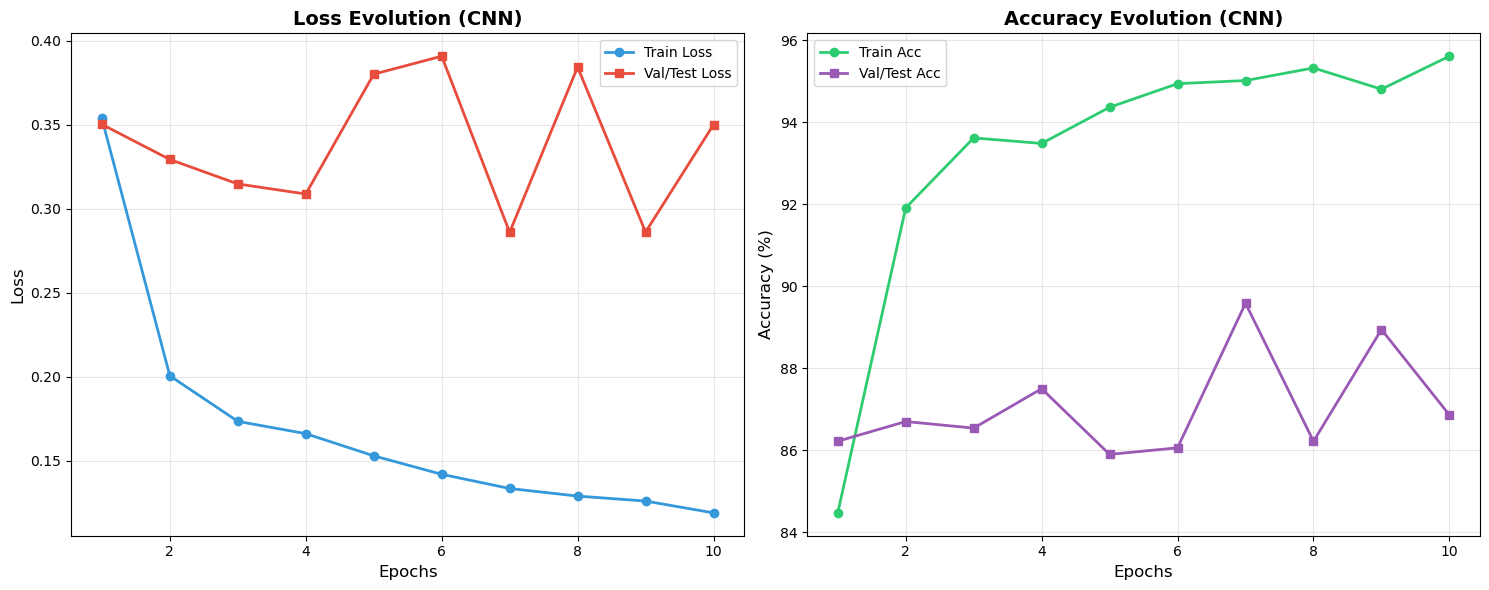


Generating predictions for evaluation...


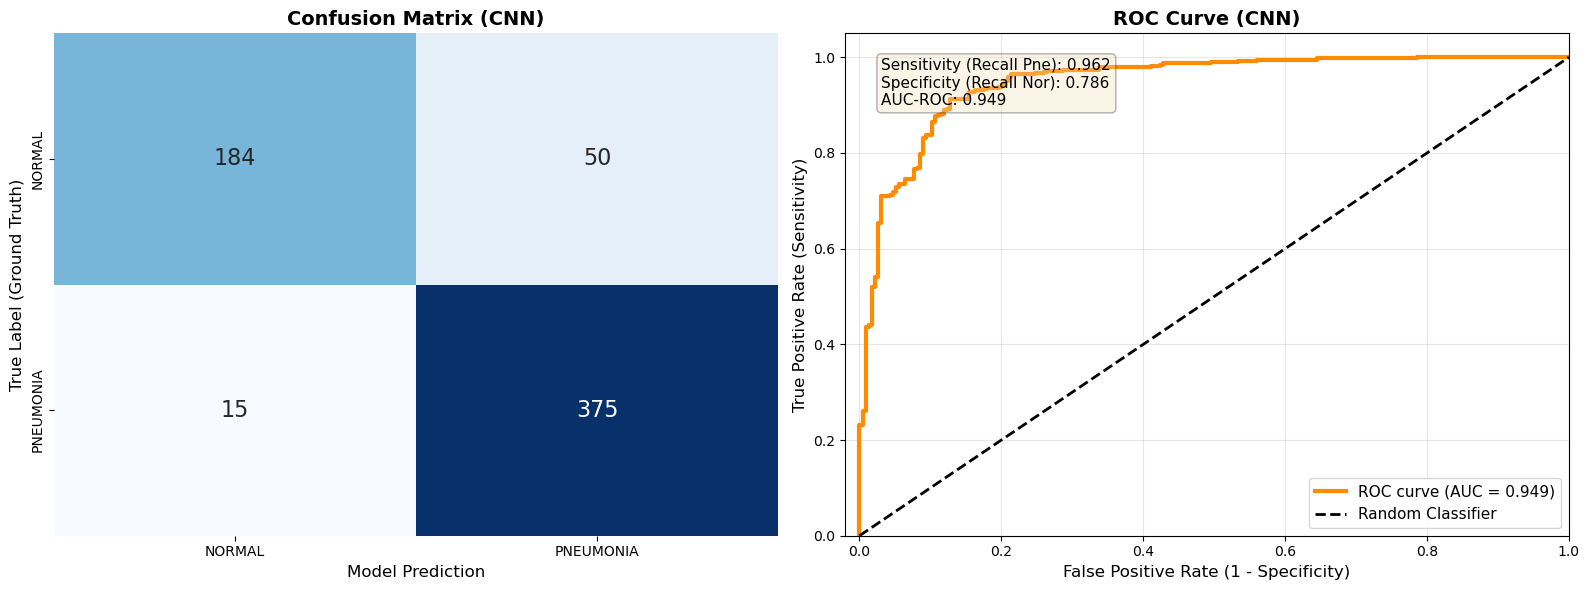


 Final Clinical Metrics:
  ➢ Sensitivity: 0.9615
  ➢ Specificity: 0.7863
  ➢ AUC-ROC:     0.9487


In [27]:
print("\n" + "="*50)
print("CNN Training")
print("="*50)

# Train the model
history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    epochs=10,
    patience=3
)

# Plot the training results
plot_training_curves(history)

# 3. Generate predictions and evaluate
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth", weights_only=True))

test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

# 4. Plot matrix and ROC
plot_confusion_matrix_and_roc(test_labels, test_preds, test_probs)